In [1]:
import requests
import time
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
audi_allroad = "https://www.ss.lv/lv/transport/cars/audi/allroad/sell/"

In [3]:
req = requests.get(audi_allroad)
req.text[:200]


'<!DOCTYPE html>\r\n<HTML><HEAD>\r\n<title>SS.LV Audi Allroad, Cenas, Pārdod - Sludinājumi</title>\r\n<meta http-equiv="Content-Type" CONTENT="text/html; charset=UTF-8">\r\n<meta name="viewport" content="user-'

In [4]:
soup = BeautifulSoup(req.text, 'lxml')


In [5]:
def getColList(soup):
    column_list = ["description","url"] # we decided to that we need these two column names no matter the html
    headline = soup.find("tr", {"id":"head_line"})
    headtds = headline.find_all("td")
    headcolumns = [el.text for el in headtds[1:]] # this will get all column names starting with 2nd in HTML
    column_list += headcolumns
    return column_list

In [6]:
column_names = getColList(soup)
column_names

['description', 'url', 'Gads', 'Tilp.', 'Nobrauk.', 'Cena']

In [7]:
trows = soup.find_all('tr')

def getRowList(soup):
    trows = soup.find_all('tr')
    aprows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]
    return aprows

In [8]:
def getRow(row,colist=column_names):
    row_tds = row.find_all('td')
    rowDict = {}
    if len(row_tds) <3: # a little sanity check
        print("Hmm bad row")
        return rowDict
    
    rowDict[colist[0]] = row_tds[2].text # so the big assumption is that we always get description in 3rd column
    rowDict[colist[1]] = "https://ss.com" + row_tds[1].find('a').get('href')
    for td,key in zip(row_tds[3:],colist[2:]): 
        rowDict[key] = td.text
    return rowDict

In [9]:
def getRows(rowlist,colist=column_names):
    return [getRow(row, colist=colist) for row in rowlist]

In [10]:
def getDFfromURL(url):
    # print("getting data from", url)
    req = requests.get(url)
    if req.status_code != 200:
        print("Request Fail with", req.status_code)
        return None # maybe return empty dataframe here
    soup = BeautifulSoup(req.text, 'lxml')
    column_names = getColList(soup)
    rowlist = getRowList(soup)
    rows = getRows(rowlist,colist=column_names)
    return pd.DataFrame(rows, columns=column_names)

In [11]:
df = getDFfromURL(audi_allroad)

df.head()

,description,url,Gads,Tilp.,Nobrauk.,Cena
0,Sīkāk informāciju zemāk uz otro norādīto talru...,https://ss.com/msg/lv/transport/cars/audi/allr...,2001,2.5D,-,"2,500 €"
1,Pārdodu ļoti uzticamu un labu auto perfektā te...,https://ss.com/msg/lv/transport/cars/audi/allr...,2013,2.0D,220 tūkst.,"9,900 €"
2,"Tiek pārdots Audi A6 Allroad, 2006.gada, 3.0D,...",https://ss.com/msg/lv/transport/cars/audi/allr...,2006,3.0D,271 tūkst.,"6,500 €"
3,"Audi Allroad Quattro , 3.0 dizelis/automats (1...",https://ss.com/msg/lv/transport/cars/audi/allr...,2007,3.0D,-,"5,950 €"
4,"Продаю Audi Allroad 2, 7 biturbo , пушка а не ...",https://ss.com/msg/lv/transport/cars/audi/allr...,2003,2.7,240 tūkst.,"4,900 €"


In [12]:
anchors = soup.find_all("a")

navs = [anchor for anchor in anchors if anchor.get("name") == "nav_id"] # get will get us None if no "name" exists
len(navs)

# could use regular expression here but we can use split 
afterpage = navs[0]['href'].split("/page")[-1] # -1 might be safer than 1 in case there is region with name page

beforedot = afterpage.split(".html")[0]

lastpage = int(beforedot)
lastpage


2

In [13]:
def getAllLocalUrls(url):
    """Get a list of all urls including paginated pages"""
    results = [url] # default is just the url if no extra pages found
    req = requests.get(url)
    if req.status_code != 200:
        print(f"Bad response! {req.status_code}")
        return []
    soup = BeautifulSoup(req.text, 'lxml')
    # we just need a one element
    prevanchor = soup.find('a', {"rel":"prev"})
    if prevanchor == None: # means there is only one page of ads
        return results
    href = prevanchor.attrs.get('href')
    lastPageNum = int(href.split('/page')[-1].split('.html')[0])
    print("Last page is",lastPageNum)
    nurls = [f"{url}page{n}.html" for n in range(2,lastPageNum+1)]
    results += nurls
    return results

In [14]:
local_urls = getAllLocalUrls(audi_allroad)
len(local_urls),local_urls[:3],local_urls[-1]

Last page is 2


(2,
 ['https://www.ss.lv/lv/transport/cars/audi/allroad/sell/',
  'https://www.ss.lv/lv/transport/cars/audi/allroad/sell/page2.html'],
 'https://www.ss.lv/lv/transport/cars/audi/allroad/sell/page2.html')

In [15]:
dlast = getDFfromURL(local_urls[-1])
dlast.shape

(20, 6)

In [16]:
def get_all_ads_df(start_url, save_excel_path=None):
    df_list=[] # so we will save our dataframes in a list
    local_urls = getAllLocalUrls(start_url)
    for url in local_urls:
        print(f"Gathering data from {url}")
        df_list.append(getDFfromURL(url))
        time.sleep(0.3) # we need this to play nice!
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
    big_df = pd.concat(df_list) # then make a big dataframe from all the small dataframes
    if save_excel_path:
        big_df.to_excel(save_excel_path)
    return big_df



In [17]:
df = get_all_ads_df(audi_allroad, "audi_allroad_28_01.xlsx")

Last page is 2
Gathering data from https://www.ss.lv/lv/transport/cars/audi/allroad/sell/
Gathering data from https://www.ss.lv/lv/transport/cars/audi/allroad/sell/page2.html


In [18]:
df.head()

,description,url,Gads,Tilp.,Nobrauk.,Cena
0,Sīkāk informāciju zemāk uz otro norādīto talru...,https://ss.com/msg/lv/transport/cars/audi/allr...,2001,2.5D,-,"2,500 €"
1,Pārdodu ļoti uzticamu un labu auto perfektā te...,https://ss.com/msg/lv/transport/cars/audi/allr...,2013,2.0D,220 tūkst.,"9,900 €"
2,"Tiek pārdots Audi A6 Allroad, 2006.gada, 3.0D,...",https://ss.com/msg/lv/transport/cars/audi/allr...,2006,3.0D,271 tūkst.,"6,500 €"
3,"Audi Allroad Quattro , 3.0 dizelis/automats (1...",https://ss.com/msg/lv/transport/cars/audi/allr...,2007,3.0D,-,"5,950 €"
4,"Продаю Audi Allroad 2, 7 biturbo , пушка а не ...",https://ss.com/msg/lv/transport/cars/audi/allr...,2003,2.7,240 tūkst.,"4,900 €"


In [19]:
# price, delete euro symbol
df["price"] = df.Cena.str.split(' ').str[0]
df.head()

,description,url,Gads,Tilp.,Nobrauk.,Cena,price
0,Sīkāk informāciju zemāk uz otro norādīto talru...,https://ss.com/msg/lv/transport/cars/audi/allr...,2001,2.5D,-,"2,500 €","2,500"
1,Pārdodu ļoti uzticamu un labu auto perfektā te...,https://ss.com/msg/lv/transport/cars/audi/allr...,2013,2.0D,220 tūkst.,"9,900 €","9,900"
2,"Tiek pārdots Audi A6 Allroad, 2006.gada, 3.0D,...",https://ss.com/msg/lv/transport/cars/audi/allr...,2006,3.0D,271 tūkst.,"6,500 €","6,500"
3,"Audi Allroad Quattro , 3.0 dizelis/automats (1...",https://ss.com/msg/lv/transport/cars/audi/allr...,2007,3.0D,-,"5,950 €","5,950"
4,"Продаю Audi Allroad 2, 7 biturbo , пушка а не ...",https://ss.com/msg/lv/transport/cars/audi/allr...,2003,2.7,240 tūkst.,"4,900 €","4,900"


In [20]:
df.price = df.price.str.replace(",","").astype('int32')
df.head()

,description,url,Gads,Tilp.,Nobrauk.,Cena,price
0,Sīkāk informāciju zemāk uz otro norādīto talru...,https://ss.com/msg/lv/transport/cars/audi/allr...,2001,2.5D,-,"2,500 €",2500
1,Pārdodu ļoti uzticamu un labu auto perfektā te...,https://ss.com/msg/lv/transport/cars/audi/allr...,2013,2.0D,220 tūkst.,"9,900 €",9900
2,"Tiek pārdots Audi A6 Allroad, 2006.gada, 3.0D,...",https://ss.com/msg/lv/transport/cars/audi/allr...,2006,3.0D,271 tūkst.,"6,500 €",6500
3,"Audi Allroad Quattro , 3.0 dizelis/automats (1...",https://ss.com/msg/lv/transport/cars/audi/allr...,2007,3.0D,-,"5,950 €",5950
4,"Продаю Audi Allroad 2, 7 biturbo , пушка а не ...",https://ss.com/msg/lv/transport/cars/audi/allr...,2003,2.7,240 tūkst.,"4,900 €",4900


In [22]:
# save file
df.to_excel("C:/temp/my_audis.xlsx")

In [24]:
df = pd.read_excel("C:/temp/my_audis.xlsx")
df.head()

,Unnamed: 0,description,url,Gads,Tilp.,Nobrauk.,Cena,price
0,0,Sīkāk informāciju zemāk uz otro norādīto talru...,https://ss.com/msg/lv/transport/cars/audi/allr...,2001,2.5D,-,"2,500 €",2500
1,1,Pārdodu ļoti uzticamu un labu auto perfektā te...,https://ss.com/msg/lv/transport/cars/audi/allr...,2013,2.0D,220 tūkst.,"9,900 €",9900
2,2,"Tiek pārdots Audi A6 Allroad, 2006.gada, 3.0D,...",https://ss.com/msg/lv/transport/cars/audi/allr...,2006,3.0D,271 tūkst.,"6,500 €",6500
3,3,"Audi Allroad Quattro , 3.0 dizelis/automats (1...",https://ss.com/msg/lv/transport/cars/audi/allr...,2007,3.0D,-,"5,950 €",5950
4,4,"Продаю Audi Allroad 2, 7 biturbo , пушка а не ...",https://ss.com/msg/lv/transport/cars/audi/allr...,2003,2.7,240 tūkst.,"4,900 €",4900


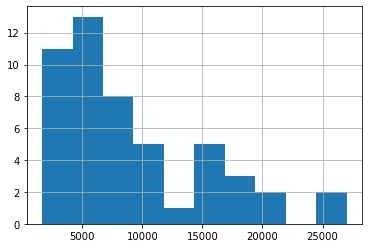

In [25]:
df.price.hist()

In [26]:
df.groupby(['Gads']).mean()

,Unnamed: 0,price
Gads,,
2000,5.000000,3000.000000
2001,14.600000,2596.000000
2002,17.000000,2763.333333
2003,7.500000,3800.000000
2004,5.000000,4075.000000
2005,28.000000,5600.000000
2006,8.600000,5902.000000
2007,18.200000,6000.000000
2009,11.000000,7530.000000
